# Citation and References

In [ ]:
#References
#https://www.analyticsvidhya.com/blog/2020/12/an-approach-towards-neural-network-based-image-clustering/

#Citation
@misc{karel horak_simon bilik_ondrej bostik_lukas kratochvila_tomas zemcik_2022,
      title={Industry Biscuit (Cookie) dataset},
      url={https://www.kaggle.com/dsv/4311115},
      DOI={10.34740/KAGGLE/DSV/4311115}, publisher={Kaggle},
      author={Karel Horak and Simon Bilik and Ondrej Bostik and Lukas Kratochvila and Tomas Zemcik}, year={2022} }

SyntaxError: ignored

# Prerequisites


In [ ]:
import numpy as np
import pandas as pd
import math
from math import floor
import os
from PIL import Image
import time
import cv2
import shutil

from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab import drive
from google.colab import files

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

# Data Importing

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_dir = "/content/drive/MyDrive/4211/IndustryBiscuit"
annotations_df = pd.read_csv(f'{drive_dir}/Annotations.csv')
print("no defect: " , annotations_df["classDescription"].value_counts()["Defect_No"])
print("shape defect: ", annotations_df["classDescription"].value_counts()["Defect_Shape"])
print("color defect: ", annotations_df["classDescription"].value_counts()["Defect_Color"])
print("object defect: ", annotations_df["classDescription"].value_counts()["Defect_Object"])
annotations_df

no defect:  1896
shape defect:  1860
color defect:  512
object defect:  632


,file,classDescription,classCode
0,0001.jpg,Defect_Shape,1
1,0002.jpg,Defect_Shape,1
2,0003.jpg,Defect_Shape,1
3,0004.jpg,Defect_Shape,1
4,0005.jpg,Defect_Shape,1
...,...,...,...
4895,4896.jpg,Defect_Shape,1
4896,4897.jpg,Defect_Shape,1
4897,4898.jpg,Defect_Shape,1
4898,4899.jpg,Defect_Shape,1


In [ ]:
download_dir = os.path.join(drive_dir, "Images")
folder_id = "1uyGspGM6LkUjWgilNJRR6bLvAMbeOoy4"

gdd.download_file_from_google_drive(file_id=folder_id, dest_path=download_dir, unzip=True)

0001.jpg Defect_Shape 1


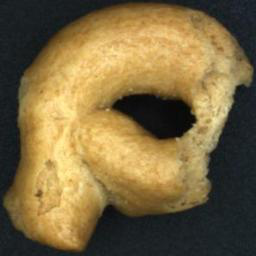

In [ ]:
image_name = "0001.jpg"
image_path = os.path.join(download_dir, image_name)
row = annotations_df.loc[annotations_df["file"] == image_name]
class_description = row["classDescription"].iloc[0]
class_code = row["classCode"].iloc[0]
print(image_name, class_description, class_code)

# Open the image file
image = Image.open(image_path)

# Show the image
image.show()

# Data Splitting and Preprocessing

In [ ]:
# Data Splitting Utilities

# Deleting "data" folder
shutil.rmtree('./data')

# Unzipping uploaded
!unzip data.zip

Archive:  data.zip
   creating: data/test/
   creating: data/test/defect_color/
  inflating: data/test/defect_color/0151.jpg  
  inflating: data/test/defect_color/0153.jpg  
  inflating: data/test/defect_color/0156.jpg  
  inflating: data/test/defect_color/0708.jpg  
  inflating: data/test/defect_color/0709.jpg  
  inflating: data/test/defect_color/0721.jpg  
  inflating: data/test/defect_color/0722.jpg  
  inflating: data/test/defect_color/0726.jpg  
  inflating: data/test/defect_color/0956.jpg  
  inflating: data/test/defect_color/0961.jpg  
  inflating: data/test/defect_color/0963.jpg  
  inflating: data/test/defect_color/0964.jpg  
  inflating: data/test/defect_color/0972.jpg  
  inflating: data/test/defect_color/0980.jpg  
  inflating: data/test/defect_color/0982.jpg  
  inflating: data/test/defect_color/0987.jpg  
  inflating: data/test/defect_color/0991.jpg  
  inflating: data/test/defect_color/0993.jpg  
  inflating: data/test/defect_color/0994.jpg  
  inflating: data/test/defe

In [ ]:
nTrain_ok = 270
nTrain_nok = 810
nValid_ok = 90
nValid_nok = 270
nTest_ok = 90
nTest_nok = 270

# Defect ratios
rNComplete = 1/3
rSObject = 1/3
rCDefect = 1/3

# Counters initialization
cTrain_ok = 0
cValid_ok = 0
cTest_ok = 0

cTrainNC_nok = 0
cValidNC_nok = 0
cTestNC_nok = 0

cTrainSO_nok = 0
cValidSO_nok = 0
cTestSO_nok = 0

cTrainCD_nok = 0
cValidCD_nok = 0
cTestCD_nok = 0

# Defect limits
nTrNC = floor(nTrain_nok * rNComplete)
nVaNC = floor(nValid_nok * rNComplete)
nTeNC = floor(nTest_nok * rNComplete)

nTrSO = floor(nTrain_nok * rSObject)
nVaSO = floor(nValid_nok * rSObject)
nTeSO = floor(nTest_nok * rSObject)

nTrCD = floor(nTrain_nok * rCDefect)
nVaCD = floor(nValid_nok * rCDefect)
nTeCD = floor(nTest_nok * rCDefect)


imPath = download_dir
anPath = os.path.join(drive_dir, 'Annotations.csv')
dsPath = './data'
# Create the directories for the image storage
if not os.path.exists(dsPath):

    # Create the folder structure
    os.mkdir(dsPath)
    os.mkdir(dsPath + '/train')
    os.mkdir(dsPath + '/train' + '/defect_no')
    os.mkdir(dsPath + '/train' + '/defect_shape')
    os.mkdir(dsPath + '/train' + '/defect_color')
    os.mkdir(dsPath + '/train' + '/defect_object')
    os.mkdir(dsPath + '/valid')
    os.mkdir(dsPath + '/valid' + '/defect_no')
    os.mkdir(dsPath + '/valid' + '/defect_shape')
    os.mkdir(dsPath + '/valid' + '/defect_color')
    os.mkdir(dsPath + '/valid' + '/defect_object')
    os.mkdir(dsPath + '/test')
    os.mkdir(dsPath + '/test' + '/defect_no')
    os.mkdir(dsPath + '/test' + '/defect_shape')
    os.mkdir(dsPath + '/test' + '/defect_color')
    os.mkdir(dsPath + '/test' + '/defect_object')


    # Load the filenames and the annotation from the .csv file
    data = pd.read_csv(anPath, usecols= ['file', 'classDescription'])

    augm = 1226

    for key in range(1, 1226):

        for temp in range(0, 4):

            if temp == 0:
                index = key
            else:
                index = augm
                augm += 1

            value = data.iloc[index - 1, :]

            # Open the image file
            im = Image.open(os.path.join(imPath, value[0]))

            # Split the images to the categories
            if value[1] == "Defect_No":
                if (cTrain_ok < nTrain_ok):
                    im.save(os.path.join(dsPath + '/train' + '/defect_no', value[0]), format='jpeg')
                    cTrain_ok += 1
                elif (cValid_ok < nValid_ok):
                    im.save(os.path.join(dsPath + '/valid' + '/defect_no', value[0]), format='jpeg')
                    cValid_ok += 1
                elif (cTest_ok < nTest_ok):
                    im.save(os.path.join(dsPath + '/test' + '/defect_no', value[0]), format='jpeg')
                    cTest_ok += 1

            elif value[1] == "Defect_Shape":
                if (cTrainNC_nok < nTrNC):
                    im.save(os.path.join(dsPath + '/train' + '/defect_shape', value[0]), format='jpeg')
                    cTrainNC_nok += 1
                elif (cValidNC_nok < nVaNC):
                    im.save(os.path.join(dsPath + '/valid' + '/defect_shape', value[0]), format='jpeg')
                    cValidNC_nok += 1
                elif (cTestNC_nok < nTeNC):
                    im.save(os.path.join(dsPath + '/test' + '/defect_shape', value[0]), format='jpeg')
                    cTestNC_nok += 1

            elif value[1] == "Defect_Color":
                if (cTrainSO_nok < nTrSO):
                    im.save(os.path.join(dsPath + '/train' + '/defect_color', value[0]), format='jpeg')
                    cTrainSO_nok += 1
                elif (cValidSO_nok < nVaSO):
                    im.save(os.path.join(dsPath + '/valid' + '/defect_color', value[0]), format='jpeg')
                    cValidSO_nok += 1
                elif (cTestSO_nok < nTeSO):
                    im.save(os.path.join(dsPath + '/test' + '/defect_color', value[0]), format='jpeg')
                    cTestSO_nok += 1

            elif value[1] == "Defect_Object":
                if (cTrainCD_nok < nTrCD):
                    im.save(os.path.join(dsPath + '/train' + '/defect_object', value[0]), format='jpeg')
                    cTrainCD_nok += 1
                elif (cValidCD_nok < nVaCD):
                    im.save(os.path.join(dsPath + '/valid' + '/defect_object', value[0]), format='jpeg')
                    cValidCD_nok += 1
                elif (cTestCD_nok < nTeCD):
                    im.save(os.path.join(dsPath + '/test' + '/defect_object', value[0]), format='jpeg')
                    cTestCD_nok += 1

    # Print dataset statistics TODO

    print("Dataset created successfully")

else:
    print("Folder structure with the dataset already exists")

Folder structure with the dataset already exists


In [ ]:
# Check/Confirm the number of splitted data
data_path = "./data"

for folder in ["train", "test", "valid"]:
    for class_name in ["defect_no", "defect_shape", "defect_color", "defect_object"]:
        folder_path = os.path.join(data_path, folder, class_name)
        file_count = len(os.listdir(folder_path))
        print(f"{folder} -> {class_name} : {file_count} files")

train -> defect_no : 270 files
train -> defect_shape : 270 files
train -> defect_color : 270 files
train -> defect_object : 270 files
test -> defect_no : 90 files
test -> defect_shape : 90 files
test -> defect_color : 90 files
test -> defect_object : 90 files
valid -> defect_no : 90 files
valid -> defect_shape : 90 files
valid -> defect_color : 90 files
valid -> defect_object : 90 files


In [ ]:
preprocessed_path = "./preprocessed_data"

# Iterate through each image in the dataset
for folder in ["train", "test", "valid"]:
    for class_name in ["defect_no", "defect_shape", "defect_color", "defect_object"]:
        class_path = os.path.join(data_path, folder, class_name)
        preprocessed_class_path = os.path.join(preprocessed_path, folder, class_name)

        os.makedirs(preprocessed_class_path, exist_ok=True)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            preprocessed_img_path = os.path.join(preprocessed_class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # normalization
            # img = img.astype('float32')
            # img -= img.mean()
            # img /= img.std()
            cv2.imwrite(preprocessed_img_path, img)

In [ ]:
# Download the splitted file
# !zip -r /content/data.zip /content/data
# files.download('/content/data.zip')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,
                                  zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './data/train',
        target_size=(256, 256),
        batch_size=32,
        # color_mode='grayscale',
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        './data/valid',
        target_size=(256, 256),
        batch_size=32,
        # color_mode='grayscale',
        class_mode='categorical')

print("Train generator:")
print("Number of batches:", len(train_generator))
print("Batch size:", train_generator.batch_size)
print("Image shape:", train_generator.image_shape)

print("\nValidation generator:")
print("Number of batches:", len(validation_generator))
print("Batch size:", validation_generator.batch_size)
print("Image shape:", validation_generator.image_shape)


Found 1080 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Train generator:
Number of batches: 34
Batch size: 32
Image shape: (256, 256, 3)

Validation generator:
Number of batches: 12
Batch size: 32
Image shape: (256, 256, 3)


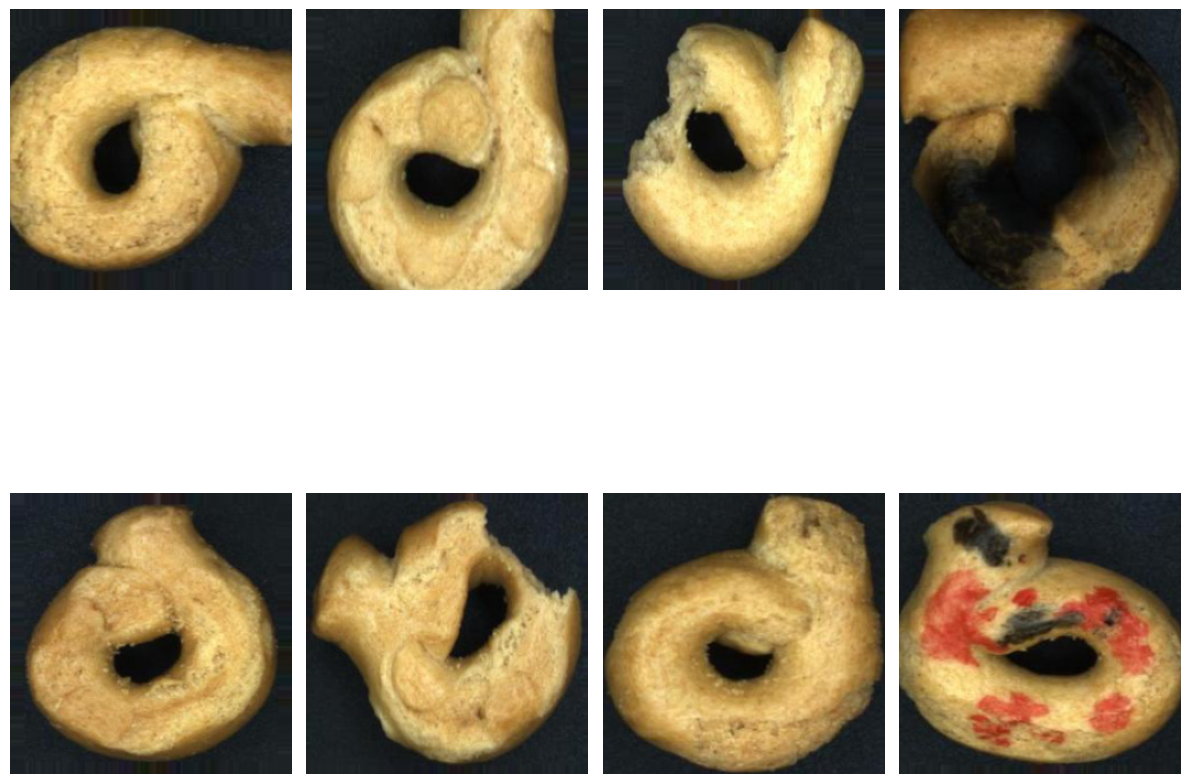

In [ ]:
# Print some of the preprocessed images
images, labels = train_generator.next()

# plot the images in a 4x4 grid
fig, axs = plt.subplots(2, 4, figsize=(12, 12))
axs = axs.ravel()

for i in np.arange(0, 8):
    axs[i].imshow(images[i])
    axs[i].axis('off')

plt.tight_layout()
plt.savefig('augmeneted.png')
plt.show()

# CNN


In [ ]:
classifier = Sequential()
classifier.add(Conv2D(256, (3, 3), input_shape=(256, 256, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# classifier.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
# classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Flatten())
classifier.add(Dense(units=32, activation='relu'))
classifier.add(Dense(units=4, activation='softmax'))
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
classifier.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_142 (Conv2D)         (None, 254, 254, 256)     7168      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 127, 127, 256)    0         
 ng2D)                                                           
                                                                 
 conv2d_143 (Conv2D)         (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_127 (MaxPooli  (None, 62, 62, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_144 (Conv2D)         (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 30, 30, 64)     

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.5):
      self.model.stop_training = True

callbacks = myCallback()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# checkpointer = keras.callbacks.ModelCheckpoint("best.h5", save_best_only =True)

# plot_compare = classifier.fit(train_generator,
#                               steps_per_epoch = (1080/32),
#                               epochs = 30,
#                               validation_data = validation_generator,
#                               validation_steps = (360/32),
#                               callbacks = [callbacks])

plot_compare = classifier.fit(train_generator,
                    steps_per_epoch=(1080/32),
                    epochs = 15,
                    validation_data=validation_generator,
                    validation_steps=(360/32), callbacks = [early_stopping])

classifier.save('./model.h5')
classifier.save_weights('./weights.h5')

Epoch 1/15
33/33 [==============================] - 22s 578ms/step - loss: 1.3731 - accuracy: 0.3093 - val_loss: 1.2310 - val_accuracy: 0.5528
Epoch 2/15
33/33 [==============================] - 20s 575ms/step - loss: 1.1208 - accuracy: 0.5000 - val_loss: 0.9459 - val_accuracy: 0.5361
Epoch 3/15
33/33 [==============================] - 20s 593ms/step - loss: 0.8542 - accuracy: 0.6250 - val_loss: 1.0776 - val_accuracy: 0.5028
Epoch 4/15
33/33 [==============================] - 19s 573ms/step - loss: 0.7762 - accuracy: 0.6824 - val_loss: 0.7211 - val_accuracy: 0.6833
Epoch 5/15
33/33 [==============================] - 21s 611ms/step - loss: 0.6695 - accuracy: 0.7204 - val_loss: 0.8164 - val_accuracy: 0.6972
Epoch 6/15
33/33 [==============================] - 20s 596ms/step - loss: 0.6971 - accuracy: 0.7296 - val_loss: 0.5640 - val_accuracy: 0.8111
Epoch 7/15
33/33 [==============================] - 19s 569ms/step - loss: 0.4903 - accuracy: 0.8139 - val_loss: 0.5831 - val_accuracy: 0.7611

In [ ]:
from tensorflow.keras.models import load_model
classifier.summary()
classifier.save("classifier_stopepoch.h5")

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_112 (Conv2D)         (None, 254, 254, 256)     7168      
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 127, 127, 256)    0         
 g2D)                                                            
                                                                 
 conv2d_113 (Conv2D)         (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 62, 62, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_114 (Conv2D)         (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 30, 30, 64)     

In [ ]:
def predict(file):
  x = load_img(file, target_size=(256,256))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = classifier.predict(x)
  print(array)
  result = array[0]
  answer = np.argmax(result)
  return answer

# [0, 0, 0, 0] = [Defect_No, Defect_Shape, Defect_Color, Defect_Object]
Defect_No_matrix = [0, 0, 0, 0]
Defect_Shape_matrix = [0, 0, 0, 0]
Defect_Color_matrix = [0, 0, 0, 0]
Defect_Object_matrix = [0, 0, 0, 0]


for i, ret in enumerate(os.walk('./data/test/defect_color')):
  print(ret)
  for i, filename in enumerate(ret[2]):
    result = predict(ret[0] + '/' + filename)
    if result == 0:
      Defect_Color_matrix[2] += 1
    elif result == 1:
      Defect_Color_matrix[0] += 1
    elif result == 2:
      Defect_Color_matrix[3] += 1
    else:
      Defect_Color_matrix[1] += 1

for i, ret in enumerate(os.walk('./data/test/defect_no')):
  for i, filename in enumerate(ret[2]):
    result = predict(ret[0] + '/' + filename)
    if result == 0:
      Defect_No_matrix[2] += 1
    elif result == 1:
      Defect_No_matrix[0] += 1
    elif result == 2:
      Defect_No_matrix[3] += 1
    else:
      Defect_No_matrix[1] += 1

for i, ret in enumerate(os.walk('./data/test/defect_object')):
  for i, filename in enumerate(ret[2]):
    result = predict(ret[0] + '/' + filename)
    if result == 0:
      Defect_Object_matrix[2] += 1
    elif result == 1:
      Defect_Object_matrix[0] += 1
    elif result == 2:
      Defect_Object_matrix[3] += 1
    else:
      Defect_Object_matrix[1] += 1

for i, ret in enumerate(os.walk('./data/test/defect_shape')):
  for i, filename in enumerate(ret[2]):
    result = predict(ret[0] + '/' + filename)
    if result == 0:
      Defect_Shape_matrix[2] += 1
    elif result == 1:
      Defect_Shape_matrix[0] += 1
    elif result == 2:
      Defect_Shape_matrix[3] += 1
    else:
      Defect_Shape_matrix[1] += 1

classes = ["Defect_No", "Defect_Shape", "Defect_Color", "Defect_Object"]

('./data/test/defect_color', [], ['0999.jpg', '0709.jpg', '0996.jpg', '1717.jpg', '4207.jpg', '0961.jpg', '4127.jpg', '0972.jpg', '3428.jpg', '1701.jpg', '4143.jpg', '4093.jpg', '4176.jpg', '4126.jpg', '4255.jpg', '4154.jpg', '1676.jpg', '1682.jpg', '4158.jpg', '0726.jpg', '4130.jpg', '1686.jpg', '4253.jpg', '3416.jpg', '4132.jpg', '0721.jpg', '3425.jpg', '1681.jpg', '0987.jpg', '4236.jpg', '4099.jpg', '0980.jpg', '3362.jpg', '4111.jpg', '1002.jpg', '3397.jpg', '1730.jpg', '4233.jpg', '0991.jpg', '3415.jpg', '0722.jpg', '4181.jpg', '0708.jpg', '3354.jpg', '1000.jpg', '4097.jpg', '0156.jpg', '1720.jpg', '0151.jpg', '0956.jpg', '1687.jpg', '0964.jpg', '0994.jpg', '3400.jpg', '4138.jpg', '1736.jpg', '4252.jpg', '0963.jpg', '0153.jpg', '3387.jpg', '1732.jpg', '3409.jpg', '0993.jpg', '4249.jpg', '1685.jpg', '4137.jpg', '4103.jpg', '4229.jpg', '0982.jpg', '4149.jpg', '4112.jpg', '3381.jpg', '4219.jpg', '1697.jpg', '3401.jpg', '3364.jpg', '1728.jpg', '4246.jpg', '4108.jpg', '1693.jpg', '3341.

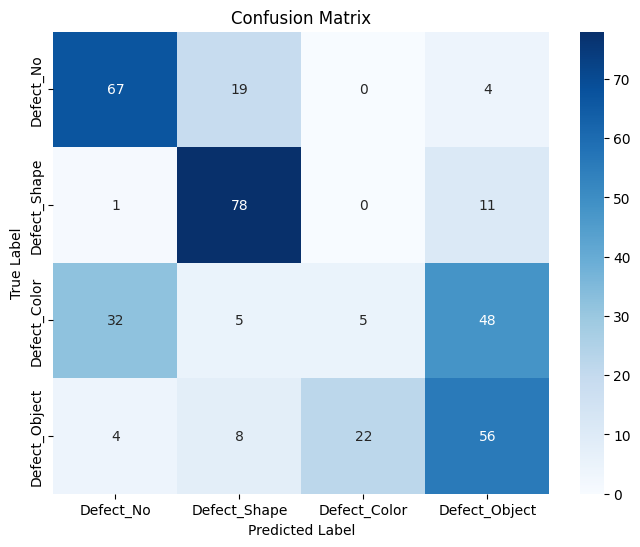

Accuracy: 0.5722222222222222
F1 scores per category:
Defect_No: 0.7444444444444445
Defect_Shape: 0.8666666666666667
Defect_Color: 0.05555555555555555
Defect_Object: 0.6222222222222222
Overall f1_score (macro): 0.5722222222222222
Overall f1_score (weighted): 1.0


In [ ]:
# Create a 2D array from the 1D arrays
data = [Defect_No_matrix, Defect_Shape_matrix, Defect_Color_matrix, Defect_Object_matrix]

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

accuracy = ((Defect_No_matrix[0]+Defect_Shape_matrix[1]+Defect_Color_matrix[2]+Defect_Object_matrix[3])/360)
print("Accuracy: " + str(accuracy))

true_positives = [Defect_No_matrix[0], Defect_Shape_matrix[1], Defect_Color_matrix[2], Defect_Object_matrix[3]]
false_positives = [(sum(Defect_No_matrix) - Defect_No_matrix[0]),
                   (sum(Defect_Shape_matrix) - Defect_Shape_matrix[1]),
                   (sum(Defect_Color_matrix) - Defect_Color_matrix[2]),
                   (sum(Defect_Object_matrix) - Defect_Object_matrix[3])]
false_negatives = [(sum(row) - row[i]) for i, row in enumerate([Defect_No_matrix, Defect_Shape_matrix, Defect_Color_matrix, Defect_Object_matrix])]

precision = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(true_positives, false_positives)]
recall = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(true_positives, false_negatives)]

f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
print("F1 scores per category:")
for i, target_name in enumerate(classes):
    print(f"{target_name}: {f1_scores[i]}")

f1_macro = sum(f1_scores) / len(f1_scores)
f1_weighted = sum([f1 * (tp + fn) for f1, tp, fn in zip(f1_scores, true_positives, false_negatives)]) / sum(true_positives)
print("Overall f1_score (macro):", f1_macro)
print("Overall f1_score (weighted):", f1_weighted)

# Clustering

In [ ]:
# Set the path to the folder containing the images
test_data_path = "./data/test"

def extract_features(image_path):
    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Resize the image to a fixed size
    resized = cv2.resize(image, (256, 256))

    # Split the image into its RGB channels
    red_channel = resized[:,:,0]
    green_channel = resized[:,:,1]
    blue_channel = resized[:,:,2]

    # Flatten the RGB channels to 1D NumPy arrays
    red_flattened = red_channel.flatten()
    green_flattened = green_channel.flatten()
    blue_flattened = blue_channel.flatten()

    # Concatenate the RGB feature vectors
    features = np.concatenate([red_flattened, green_flattened, blue_flattened])

    return features


# Initialize an empty list to store the feature vectors
features = []

# Initialize an empty list to store the labels of the images
labels = []

# Loop through each class in the "test" folder
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)

    # Loop through each image in the class folder and extract its features
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        feature_vector = extract_features(image_path)
        features.append(feature_vector)
        labels.append(class_name)

# Convert the list of feature vectors and labels to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Perform clustering using K-means
kmeans = KMeans(n_clusters=4, random_state=4211).fit(features)

temp_labels = np.copy(kmeans.labels_)
temp_labels[kmeans.labels_ == 0] = 2
temp_labels[kmeans.labels_ == 1] = 0
temp_labels[kmeans.labels_ == 2] = 3
temp_labels[kmeans.labels_ == 3] = 1
kmeans.labels_ = temp_labels

# Print the cluster labels assigned to each image
print(kmeans.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 3 1 1 0 0 0 3 3 0 3 0 1 0 0 3 0 0 3 0 1 0 1 2 0 3 3 1 1 0 3 3 3 0 1 1 0
 0 2 2 0 0 3 3 1 3 0 1 0 0 0 1 1 1 3 2 0 0 0 3 1 2 2 0 1 3 3 1 3 3 1 3 0 0
 0 3 0 0 1 1 3 2 3 0 0 1 1 0 1 1 3 3 3 3 2 2 2 2 2 2 2 2 2 3 3 3 3 2 3 3 2
 3 2 3 1 0 3 3 3 2 3 3 2 2 3 2 3 2 2 2 3 3 3 3 1 3 2 1 3 2 1 1 2 2 2 2 2 1
 3 3 3 2 1 2 2 2 2 3 3 2 1 1 2 2 3 2 2 0 3 3 1 3 3 3 3 3 2 3 3 2 2 1 1 1 1
 1 1 1 2 2 1 0 0 0 0 0 0 1 0 0 0 1 1 2 1 1 0 0 0 1 1 0 1 0 1 1 2 1 1 1 1 2
 0 1 2 2 2 1 0 0 1 0 1 0 2 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 2 2 2 1 0
 1 2 1 0 0 0 0 1 2 1 2 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1]


In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Initialize an empty list to store the feature vectors
features = []

# Initialize an empty list to store the labels of the images
labels = []

# Loop through each class in the "test" folder
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)

    # Loop through each image in the class folder and extract its features
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        feature_vector = extract_features(image_path)
        features.append(feature_vector)
        labels.append(class_name)

# Convert the list of feature vectors and labels to NumPy arrays
features = np.array(features)
labels = np.array(labels)

# Perform clustering using Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=4).fit(features)

temp_labels = np.copy(hc.labels_)
temp_labels[hc.labels_ == 0] = 0
temp_labels[hc.labels_ == 1] = 3
temp_labels[hc.labels_ == 2] = 1
temp_labels[hc.labels_ == 3] = 2
hc.labels_ = temp_labels

print(hc.labels_)

[0 3 1 1 0 1 0 3 3 0 3 1 1 0 0 3 0 0 3 0 1 0 1 2 0 3 3 1 1 0 3 3 3 1 1 1 0
 0 2 2 0 0 3 2 1 3 0 1 0 0 0 1 1 1 3 2 0 0 0 3 1 2 2 0 1 3 3 1 3 3 1 3 0 0
 0 3 0 0 1 1 3 3 3 0 0 1 1 0 1 1 3 3 3 3 2 2 1 2 3 2 3 2 2 3 2 3 3 3 3 3 2
 3 2 3 1 1 3 3 3 2 3 3 2 2 3 2 3 1 3 3 3 3 3 3 0 3 3 1 3 2 1 1 3 3 2 2 2 1
 3 2 3 2 1 2 2 2 3 3 3 2 1 1 2 2 3 3 3 2 3 3 1 3 3 3 3 3 2 3 3 2 2 2 1 1 2
 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 1 1 1 1 2
 1 1 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 2 2 1 2 1 1
 1 2 2 1 1 1 1 1 2 2 2 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1
 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1]


In [ ]:
# Define a dictionary to map class names to cluster labels
class_to_label = {
    "defect_no": 0,
    "defect_shape": 1,
    "defect_color": 2,
    "defect_object": 3
}

# Create an array of the true labels for each image
true_labels = []
for c in labels:
    true_label = class_to_label[c]
    true_labels.append(true_label)
true_labels = np.array(true_labels)

# Compare the true labels with the cluster labels
print("True labels:", true_labels)
print("KMeans Cluster labels:", kmeans.labels_)
accuracy = np.sum(true_labels == kmeans.labels_) / len(true_labels)
print("KMeans Clustering accuracy:", accuracy)

# Create an array of the true labels for each image
true_labels_hc = []
for c in labels:
    true_label_hc = class_to_label[c]
    true_labels_hc.append(true_label_hc)
true_labels_hc = np.array(true_labels_hc)

print("True labels:", true_labels_hc)
print("Hierarchical Cluster labels:", hc.labels_)
accuracy = np.sum(true_labels_hc == hc.labels_) / len(true_labels_hc)
print("Hierarchical Clustering accuracy:", accuracy)

True labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
KMeans Cluster labels: [0 3 1 1 0 0 0 3 3 0 3 0 1 0 0 3 0 0 3 0 1 0 1 2 0 3 3 1 1 0 3 3 3 0 1 1 0
 0 2 2 0 0 3 3 1 3 0 1 0 0 0 1 1 1 3 2 0 0 0 3 1 2 2 0 1 3 3 1 3 3 1 3 0 0
 0 3 0 0 1 1 3 2 3 0 0 1 1 0 1 1 3 3 3 3 2 2 2 2 2 2 2 2 2 3 3 3 3 2 3 3 2
 3 2 3 1

Confusion matrix:
[[44 46  0  0]
 [33 41 16  0]
 [35 24  7 24]
 [ 2 10 38 40]]


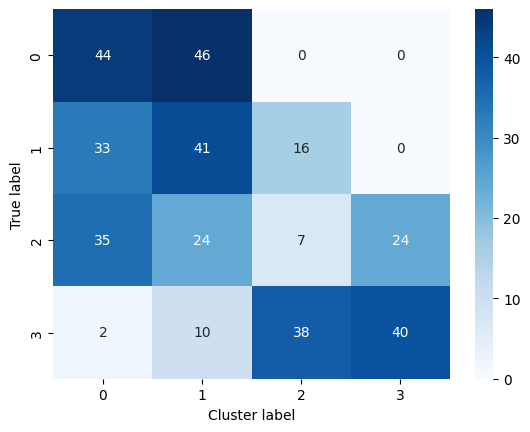

Confusion matrix:
[[44 46  0  0]
 [ 0 62 28  0]
 [32 27  7 24]
 [ 1 12 28 49]]


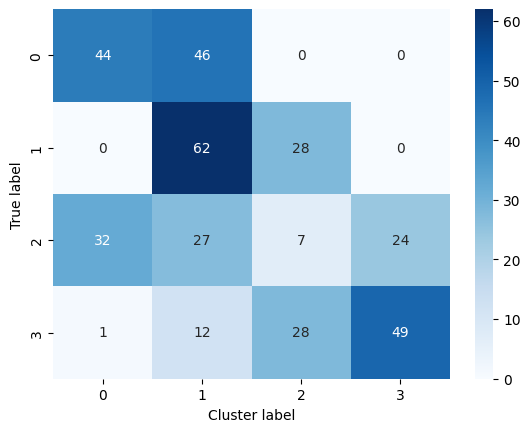

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels, kmeans.labels_)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Cluster label")
plt.ylabel("True label")
plt.show()


cm = confusion_matrix(true_labels_hc, hc.labels_)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Cluster label")
plt.ylabel("True label")
plt.show()

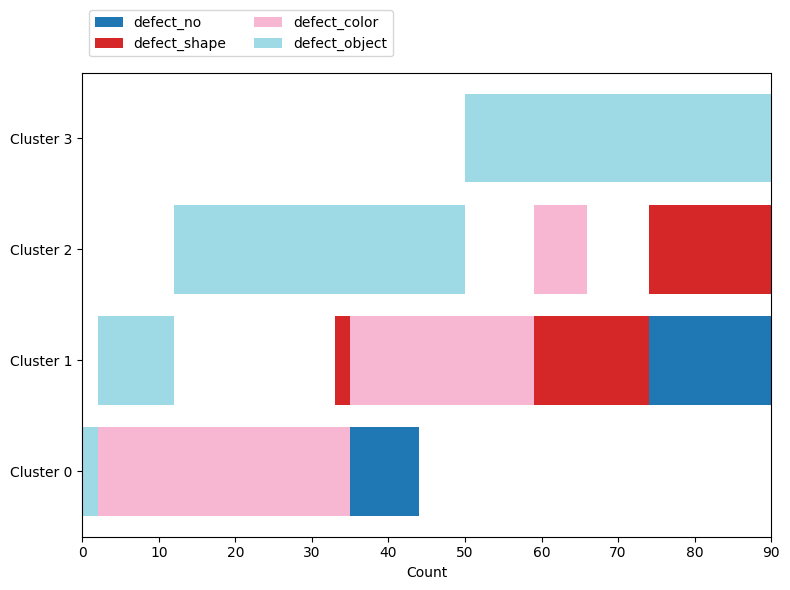

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of samples in each cluster
cluster_counts = np.bincount(kmeans.labels_)

class_names = ["defect_no", "defect_shape",  "defect_color", "defect_object"]

# Initialize an empty dictionary to store the counts of true labels in each cluster
label_counts = {}
for i in range(len(true_labels)):
    label = true_labels[i]
    cluster = kmeans.labels_[i]
    if cluster not in label_counts:
        label_counts[cluster] = np.zeros(len(class_names))
    label_counts[cluster][label] += 1

# Create a horizontal bar chart to show the distribution of true labels across clusters
fig, ax = plt.subplots(figsize=(8, 6))
y_pos = np.arange(len(class_names))
colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))
for i, label_name in enumerate(class_names):
    label_counts_list = [label_counts[c][i] for c in range(len(cluster_counts))]
    ax.barh(y_pos, label_counts_list, height=0.8, left=np.cumsum(label_counts_list)-label_counts_list, color=colors[i], label=label_name)
ax.set_yticks(y_pos)
ax.set_yticklabels(['Cluster {}'.format(c) for c in range(len(cluster_counts))])
ax.set_xlabel('Count')
ax.legend(ncol=2, bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
plt.tight_layout()
plt.show()

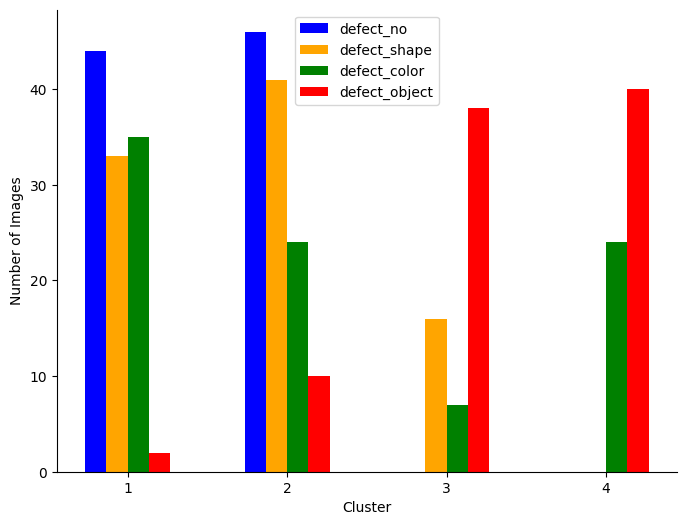

In [ ]:
# Count the number of true labels in each cluster
counts = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        counts[i, j] = np.sum((kmeans.labels_ == i) & (true_labels == j))

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']
for i in range(4):
    ax.bar(np.arange(4) - 0.2 + 0.4*i/(4-1), counts[:,i], width=0.4/(4-1),
           color=colors[i], align='center', label=class_names[i])

ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Images')
ax.set_xticks(np.arange(4))
ax.set_xticklabels(np.arange(4)+1)
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')

plt.show()

Text(0, 0.5, 'PCA Feature 2')

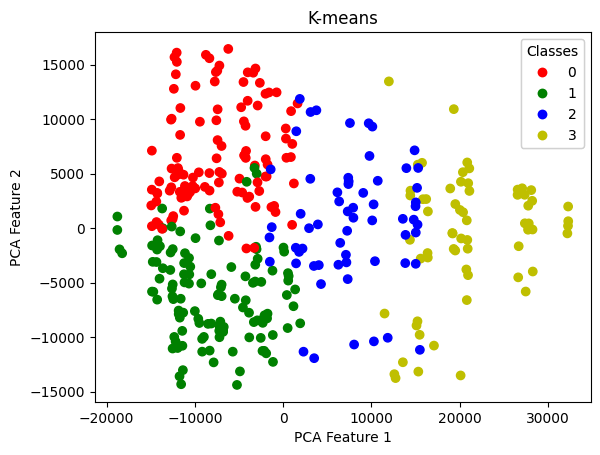

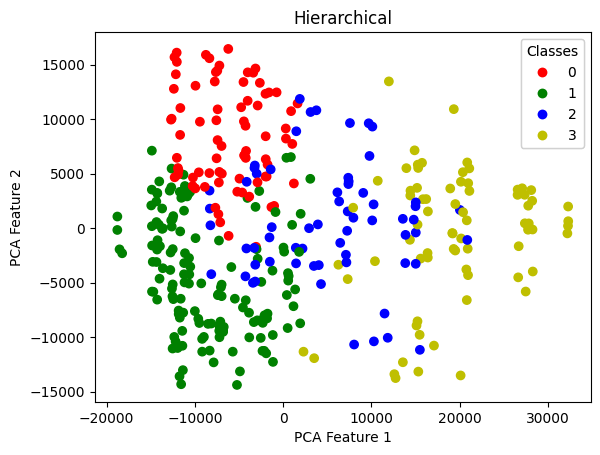

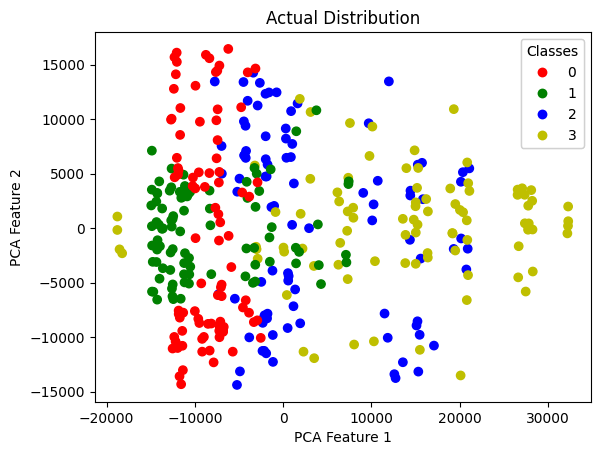

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality of the feature vectors to 2D
pca = PCA(n_components=2, random_state=4211)
pca_features = pca.fit_transform(features)

class_colors = ['r', 'g', 'b', 'y']

# Plot the feature vectors in a scatterplot with colors representing the predicted clusters
fig, ax = plt.subplots()
scatter = ax.scatter(pca_features[:,0], pca_features[:,1], c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(class_colors))

# Add a colorbar to the plot to show which color represents which class
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title("K-means")
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')

fig, ax = plt.subplots()
scatter = ax.scatter(pca_features[:,0], pca_features[:,1], c=hc.labels_, cmap=matplotlib.colors.ListedColormap(class_colors))
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title("Hierarchical")
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')

fig, ax = plt.subplots()
scatter = ax.scatter(pca_features[:,0], pca_features[:,1], c=true_labels, cmap=matplotlib.colors.ListedColormap(class_colors))
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title("Actual Distribution")
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')

# CNN and Clustering Combination and Evaluation


1/1 [==============================] - 0s 23ms/step
[[0.000000e+00 1.000000e+00 0.000000e+00 4.396906e-20]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 17ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 20ms/step
[[0.         0.98126584 0.         0.01873414]]
1/1 [==============================] - 0s 33ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 26ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 28ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 38ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 34ms/step
[[0.0000000e+00 3.1148636e-05 0.0000000e+00 9.9996889e-01]]
1/1 [==============================] - 0s 40ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 55ms/step
[[0. 1. 0. 0.]]
1/1 [==============================] - 0s 28ms/step
[[0. 0. 0. 1.]]
1/1 [==============================] - 0s 30ms/step
[[0.0000000e+00 

Text(0.5, 1.0, 'Predicted distribution')

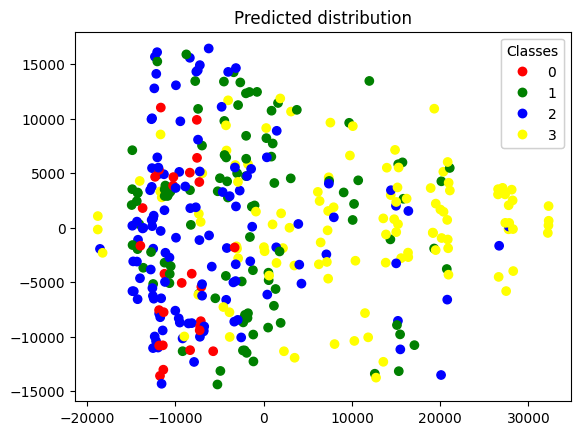

In [ ]:
class_names = ['defect_no', 'defect_shape', 'defect_color', 'defect_object']
predicted_labels = []
for c in class_names:
    for i, ret in enumerate(os.walk(f'./data/test/{c}')):
        for i, filename in enumerate(ret[2]):
            if filename.startswith("."):
                continue
            result = predict(ret[0] + '/' + filename)
            predicted_labels.append(result)

predicted_labels = np.array(predicted_labels)
print(predicted_labels);


Text(0, 0.5, 'PCA Feature 2')

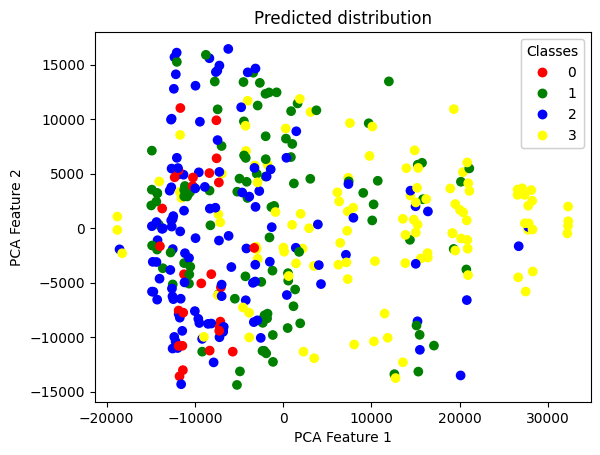

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(pca_features[:,0], pca_features[:,1], c=predicted_labels, cmap=matplotlib.colors.ListedColormap(class_colors))
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title("Predicted distribution")
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')

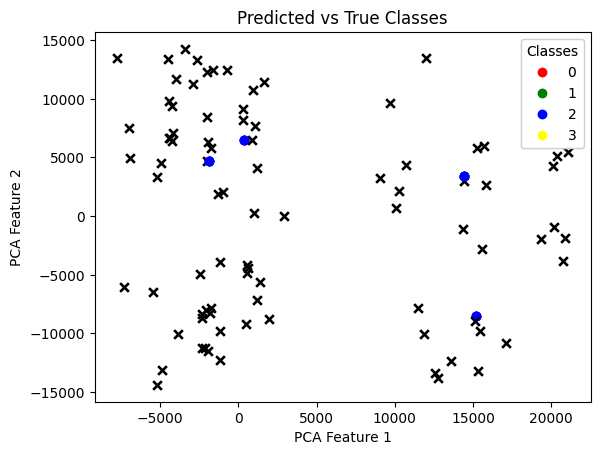

In [ ]:
fig, ax = plt.subplots()
for c in class_names:
    for i, ret in enumerate(os.walk(f'./data/test/{c}')):
        for j, filename in enumerate(ret[2]):
          if predicted_labels[j] == true_labels[j]:
              marker = 'o'
              color = class_colors[true_labels[j]]
          else:
              marker = 'x'
              color = 'black'
          ax.scatter(pca_features[j, 0], pca_features[j, 1], c=color, marker=marker)
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)
ax.set_title('Predicted vs True Classes')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
plt.show()

# Software Details


In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!nvidia-smi

Thu May  4 14:48:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |  13149MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version

Python 3.10.11


In [ ]:
print(keras.__version__)

2.12.0


In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
print(cv2.__version__)

4.7.0


In [ ]:
print(sns.__version__)

0.12.2


In [ ]:
print(np.__version__)

1.22.4


In [ ]:
print(matplotlib.__version__)

3.7.1


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   24G   55G  31% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  841M  58% /usr/sbin/docker-init
tmpfs           6.4G  2.9M  6.4G   1% /var/colab
/dev/sda1        75G   44G   31G  59% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G     0   15G   0% /content/drive


In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           12Gi       7.5Gi       176Mi        18Mi       5.0Gi       4.9Gi
Swap:            0B          0B          0B
